In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from filterpy.kalman.sigma_points import MerweScaledSigmaPoints

from csnukf import ClosedSkewNormal
from csnukf.examples import plot_effect_of_csn_parameters

# A skewed unscented Kalman filter

Reference:

- **Javad Rezaie & Jo Eidsvik (2016)** A skewed unscented Kalman filter, International Journal of Control, 89:12, 2572-2583, DOI: [10.1080/00207179.2016.1171912](https://www.tandfonline.com/doi/full/10.1080/00207179.2016.1171912)

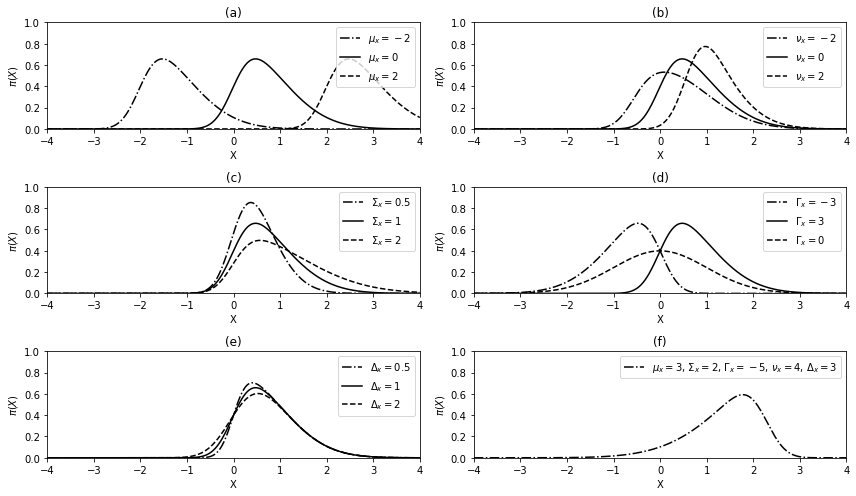

In [2]:
fig, axes = plot_effect_of_csn_parameters()

Effects of changing the CSN distributions parameters (the reference parameters are $\mu_X = 0$, $v_X=0$, $\Sigma_X = 1$, $\Gamma_X = 3$, $\Delta_X = 1$):
sensitivity to (a) $\mu_X$; (b) $v_X$; (c) $\Sigma_X$; (d) $\Gamma_X$; (e) $\Delta_X$; (f) all parameters change together.

Reference: [Javad Rezaie & Jo Eidsvik (2016)](https://www.tandfonline.com/doi/full/10.1080/00207179.2016.1171912), Figure 2.

In [3]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints
from filterpy.kalman.unscented_transform import unscented_transform

In [4]:
g = lambda x : -np.sin(2*x/5)

# prior distribution
csn_prior_dist = ClosedSkewNormal(mu_z=-1.0, Sigma_z=2.5, Gamma_z=2.0, nu_z=-.5, Delta_z=1)
mu_prior, P_prior, n, q = csn_prior_dist.get_mvn_parameters()
SigmaPoints = MerweScaledSigmaPoints(2, alpha=0.8, beta=2., kappa= 0.0)
sigmas_prior = SigmaPoints.sigma_points(mu_prior.flatten(), P_prior)
Wm = SigmaPoints.Wm
Wc = SigmaPoints.Wc

# propagation
sigmas_pos = sigmas_prior.copy()
sigmas_pos[:,0] = g(sigmas_pos[:,0])
mu_pos, P_pos = unscented_transform(sigmas_pos, Wm, Wc, noise_cov=None,
                        mean_fn=None, residual_fn=None)

# forward propagated distribution
csn_pos_dist = ClosedSkewNormal(
    mu=mu_pos, 
    Sigma=P_pos,
    n=1, q=1
)

/var/folders/v_/2c2sr_md5hv553gvh8hy6dz80000gn/T/ipykernel_42871/1672630651.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  axes[0,1].contour(X, Y, csn_prior_dist.pdf_mvn(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of X")
/var/folders/v_/2c2sr_md5hv553gvh8hy6dz80000gn/T/ipykernel_42871/1672630651.py:35: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1,1].contour(X, Y, csn_pos_dist.pdf_mvn(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of Y")


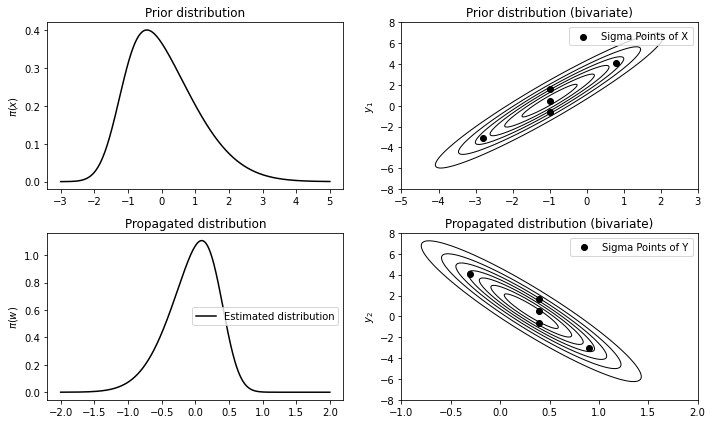

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

x_axis = np.linspace(-3, 5, num=500)
x_biv = np.linspace(-5, 3, num = 250)
y_biv = np.linspace(-8, 8, num = 250)
X, Y = np.meshgrid(x_biv, y_biv)
pos = np.dstack((X, Y))

axes[0,0].set_title("Prior distribution")
axes[0,0].plot(x_axis, csn_prior_dist.pdf_z(x_axis), color= 'k')
axes[0,0].set_ylabel("$X$")
axes[0,0].set_ylabel("$\pi(x)$")


axes[0,1].set_title("Prior distribution (bivariate)")
axes[0,1].contour(X, Y, csn_prior_dist.pdf_mvn(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of X")
axes[0,1].scatter(sigmas_prior[:,0], sigmas_prior[:,1], color='k', label="Sigma Points of X")
axes[0,1].set_ylabel("$X$")
axes[0,1].set_ylabel("$y_1$")
axes[0,1].legend()

x_axis = np.linspace(-2, 2, num = 500)
x_biv = np.linspace(-1, 2, num = 250)
y_biv = np.linspace(-8, 8, num = 250)
X, Y = np.meshgrid(x_biv, y_biv)
pos = np.dstack((X, Y))

axes[1,0].set_title("Propagated distribution")
axes[1,0].plot(x_axis, csn_pos_dist.pdf_z(x_axis), color= 'k', label="Estimated distribution")
axes[1,0].set_ylabel("$W$")
axes[1,0].set_ylabel("$\pi(w)$")
axes[1,0].legend()

axes[1,1].set_title("Propagated distribution (bivariate)")
axes[1,1].contour(X, Y, csn_pos_dist.pdf_mvn(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of Y")
axes[1,1].scatter(sigmas_pos[:,0], sigmas_pos[:,1], color='k', label="Sigma Points of Y")
axes[1,1].set_ylabel("$X$")
axes[1,1].set_ylabel("$y_2$")
axes[1,1].legend()

fig.tight_layout()

The CSN distribution estimation by SUT on extended space for the function $w = - \sin (2x/5)$

Reference: [Javad Rezaie & Jo Eidsvik (2016)](https://www.tandfonline.com/doi/full/10.1080/00207179.2016.1171912), Figure 3.

# CSNUKF validation with UKF

Basic testing of of CSN and UKF.

In [6]:
from filterpy.kalman.UKF import UnscentedKalmanFilter
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints

In [7]:
# general parameters
x, P = 5, 0.8
fx = lambda x, dt : 1.2*x*dt
hx = lambda x : x

# observations
time   = [1    , 2    , 3    , 4    , 5   , 6    , 7    , 8   , 9    , 10  ]
z_list = [None , None , None , None , 11. , None , None , 26. , None,  30. ]
R_list = [None , None , None , None , 2.0 , None , None , 2.0 , None,  2.0 ]

In [8]:
# Unscented Kalman filter
ukf = UnscentedKalmanFilter(
    dim_x=1, dim_z=1, dt=1, fx=fx, hx=hx, points= MerweScaledSigmaPoints(1, alpha=0.001, beta=2, kappa=0))
ukf.x, ukf.P = x, P
ukf_results = [[0, x, P]]
for t, z, R in zip(time, z_list, R_list):
    ukf.predict()
    ukf_results.append([t, float(ukf.x), float(ukf.P)])
    if z is not None:
        ukf.update(z, R)
        ukf_results.append([t, float(ukf.x), float(ukf.P)])
ukf_results = np.array(ukf_results)

In [9]:
# adaptations for bivariate
fx = lambda x, dt : np.array([1.2*x[0]*dt, x[1]])
hx = lambda x : np.array([x[0]])

csn = ClosedSkewNormal(mu_z=5, Sigma_z=0.8, Gamma_z=0.0, nu_z=0.0, Delta_z=2)

# Closed Skewed Normal Unscented Kalman Filter
csnukf = UnscentedKalmanFilter(
    dim_x=2, dim_z=1, dt=1, fx=fx, hx=hx, points= MerweScaledSigmaPoints(2, alpha=0.001, beta=2, kappa=0))
csnukf.x, csnukf.P = csn.mu.flatten(), csn.Sigma
csnukf_results = [[0, csnukf.x[0], csnukf.P[0,0]]]
for t, z, R in zip(time, z_list, R_list):
    csnukf.predict()
    csnukf_results.append([t, csnukf.x[0], csnukf.P[0,0]])
    if z is not None:
        csnukf.update(z, R)
        csnukf_results.append([t, csnukf.x[0], csnukf.P[0,0]])
csnukf_results = np.array(csnukf_results)

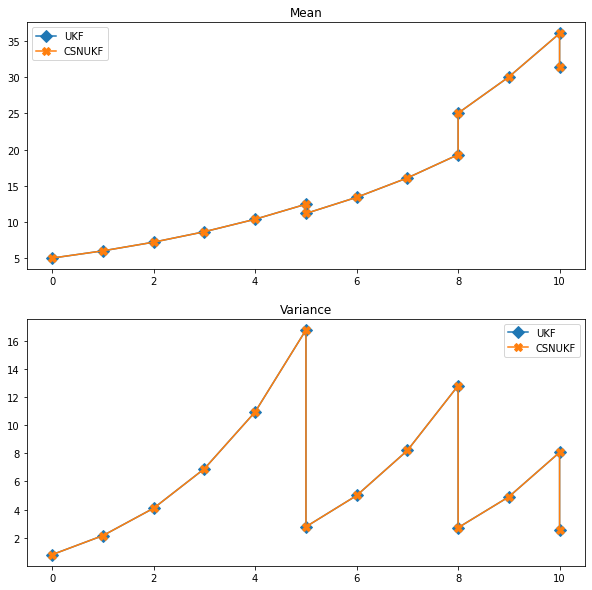

In [10]:
# plotting
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

axes[0].set_title("Mean")
axes[0].plot(ukf_results[:,0], ukf_results[:,1], label='UKF', marker="D", ms=8)
axes[0].plot(csnukf_results[:,0], csnukf_results[:,1], label='CSNUKF', marker="X", ms=8)
axes[0].legend()
axes[1].set_title('Variance')
axes[1].plot(ukf_results[:,0], ukf_results[:,2], label='UKF', marker="D", ms=8)
axes[1].plot(csnukf_results[:,0], csnukf_results[:,2], label='CSNUKF', marker="X", ms=8)
axes[1].legend()

# Numerical experiments
Numerical examples for the paper.

In [11]:
# TODO

## Re-entering body to the atmosphere

In [12]:
# differential equation
def f(x):
    x_pos = np.array(
        [
            -x[1],
            -beta*x[1]**2*np.exp(-gamma*x[0])
        ]
    )
    
    return x_pos

In [13]:
q = 2

# constants
beta = 2e-3
gamma = 5e-5
lambda_l = 0

mu_0 = np.array([30, 2])*1e4 # altitude and velocity
Delta_0 = np.eye(2)*(1 - lambda_l**2)
Sigma_x = np.diag([1e3, 4e2])

# time
T = 200 # s
h = 1
T_arr = np.linspace(0, T, int(T/h)+1)

In [15]:
# real trajectory
y = mu_0.copy()
y_arr = [y.copy()]

for t in T_arr[1:]:
    
    # Rungge-Kutta 4th order
    k1 = f(y)
    y1 = y + k1*h/2
    k2 = f(y1)
    y2 = y + k2*h/2
    k3 = f(y2)
    y3 = y + k3*h/2
    k4 = f(y3)
    y4 = y + k4*h/2
    m = (k1 + 2*k2 + 2*k3 + k4)/6
    y = y + m*h
    
    y_arr.append(y.copy())
y_arr = np.vstack(y_arr)

In [ ]:
ClosedSkewNormal(
    mu_z=mu_0, 
    Sigma_z=Sigma_x, 
    Gamma_z=lambda_l*Sigma_x**(1/2), 
    nu_z=np.zeros(2), 
    Delta_z=Delta_0
)

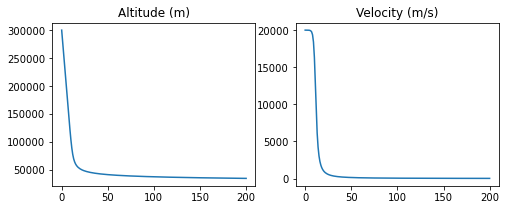

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8,3))

ax = axes[0]
ax.set_title("Altitude (m)")
ax.plot(T_arr, y_arr[:, 0])

ax = axes[1]
ax.set_title("Velocity (m/s)")
ax.plot(T_arr, y_arr[:, 1])

## Simple pendulum

In [17]:
g = 9.81 # m/s
L = 2.0 # m

Tp = 0.05 # s

